In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

from utils import count_with_tolerance

sns.set_theme(style="darkgrid")

In [ ]:
# Configuration parameters
MIN_COUNT = 50
MIN_SLIDES = 5
CLUSTER_TOLERANCE = 0.2
COUNT_TOLERANCE = 0.05

In [3]:
# Load the configuration file
PATH_TO_DATA = "data_external/new_lames"

# list the slides in the data directory
slides = os.listdir(PATH_TO_DATA)

In [4]:
# plotting the peaks
masses_df = pd.concat([pd.read_csv(f"{PATH_TO_DATA}/{slide}/results/peaks_mz.csv") for slide in slides])[['mass', 'count']]

# Filter peaks with count > 50
masses = masses_df[masses_df['count'] > MIN_COUNT]['mass'].values
print(f"Total number of peaks: {len(masses)}")

# Sorting the peaks
masses = np.sort(masses)

Total number of peaks: 130704


In [5]:
# Compute the condensed distance matrix
dist_matrix = pdist(X=masses.reshape(-1, 1), metric='euclidean')

# Perform hierarchical clustering
Z = linkage(dist_matrix, method='ward')

In [6]:
# Cutting the dendrogram to form clusters
clusters_labels = fcluster(Z, t=CLUSTER_TOLERANCE, criterion='distance')

In [7]:
# Create a pandas DataFrame to easily group the data
clusters_df = pd.DataFrame({'mass': masses, 'cluster': clusters_labels})

# Group by the 'cluster' column and calculate the median of the 'mass' for each group
clusters_df = clusters_df.groupby('cluster')['mass'].median()

# Order the clusters by their median values
clusters_df = clusters_df.sort_values().reset_index()

# Reorder the columns to have 'mass' first
clusters_df = clusters_df[['mass', 'cluster']]

In [8]:
# Count the number of peaks in each cluster with a tolerance
clusters_df['counts'] = count_with_tolerance(reference=clusters_df['mass'].values,
                                             numbers=masses,
                                             tolerance=COUNT_TOLERANCE)

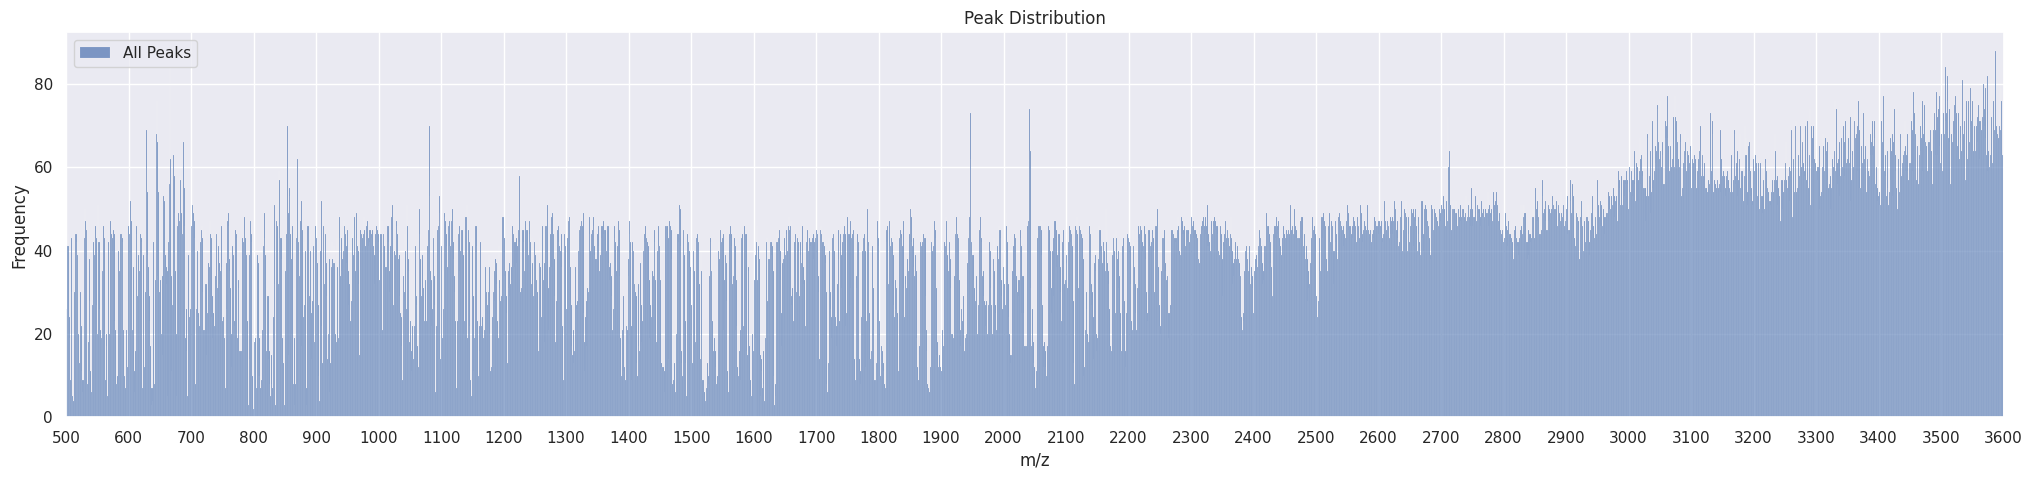

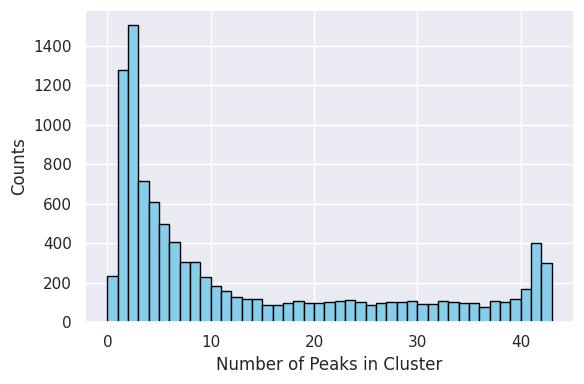

In [ ]:
mass = masses[masses < 4000]

# Plotting the peaks from different slides
plt.figure(figsize=(25, 5))
plt.hist(mass, bins=np.linspace(int(min(mass)), int(max(mass)), int(max(mass)-min(mass))), alpha=0.7, label='All Peaks', linewidth=0.1)
plt.xlabel('m/z')
plt.ylabel('Frequency')
plt.title('Peak Distribution')
plt.xlim(min(mass), max(mass))
plt.xticks(np.arange(min(mass), max(mass), 100), rotation=0)
plt.legend()
plt.show()

# Plotting the clusters histogram
plt.figure(figsize=(6, 4))
plt.hist(clusters_df['counts'], bins=np.linspace(0, max(clusters_df['counts']), max(clusters_df['counts']) + 1), color='skyblue', edgecolor='black')
plt.xlabel('Number of Peaks in Cluster')
plt.ylabel('Counts')
plt.tight_layout()
plt.show()

In [10]:
# Filter clusters with counts >= MIN_SLIDES
peaks_ref = clusters_df[clusters_df['counts'] >= MIN_SLIDES]

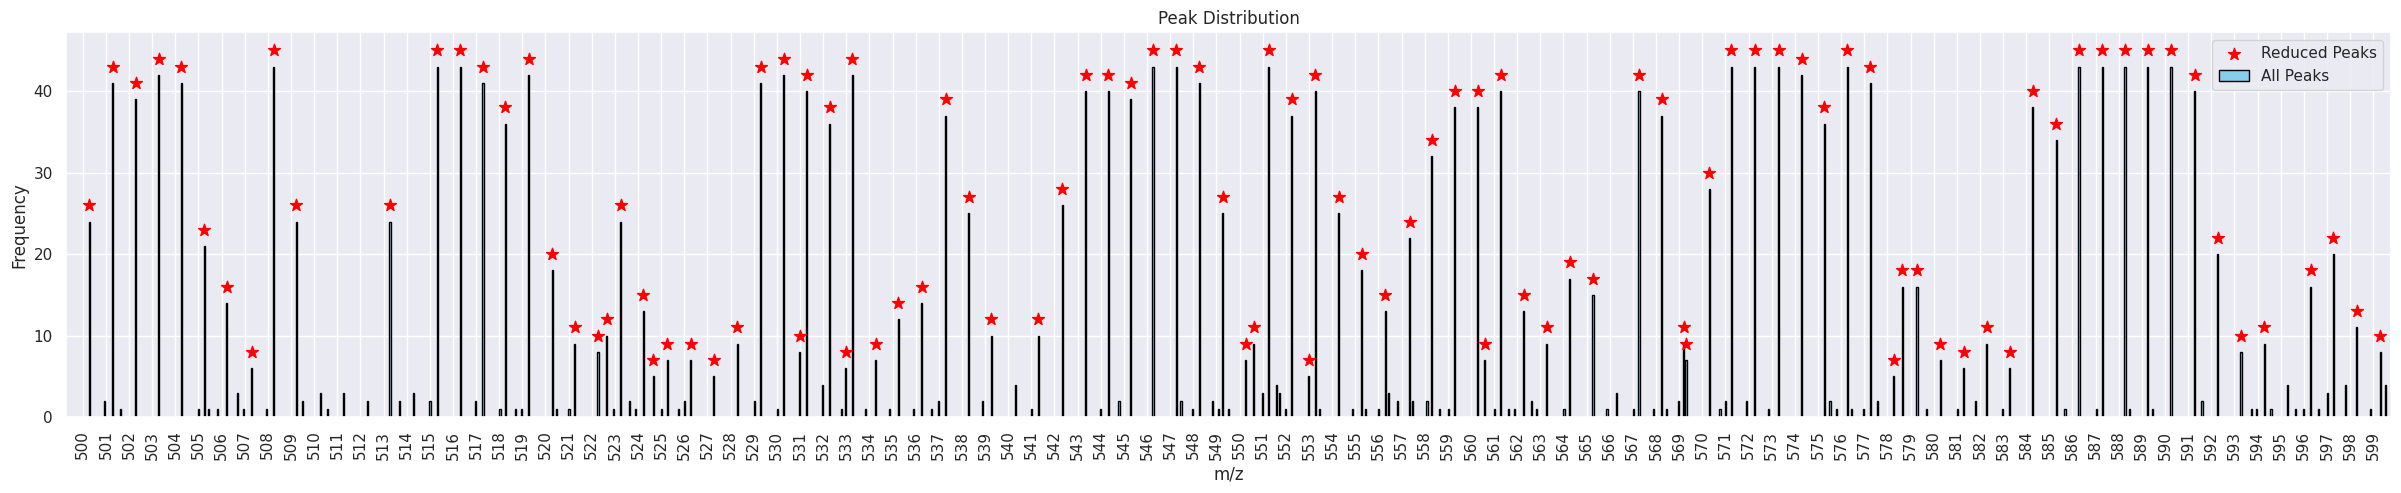

In [ ]:
# Filter peaks
peaks = clusters_df[clusters_df['mass'] < 600]

# Plotting the filtered peaks
plt.figure(figsize=(30, 5))
plt.bar(x=peaks['mass'], height=peaks['counts'], width=0.05, color='skyblue', edgecolor='black', label='All Peaks')
plt.scatter(x=peaks_ref['mass'], y=peaks_ref['counts']+2, color='red', marker='*', s=80, label='Reduced Peaks')
plt.xlabel('m/z')
plt.ylabel('Frequency')
plt.title('Peak Distribution')
plt.xlim(peaks['mass'].min()-1, peaks['mass'].max())
plt.xticks(np.arange(int(peaks['mass'].min()), int(peaks['mass'].max()+1), 1), rotation=90)
plt.legend()
plt.show()

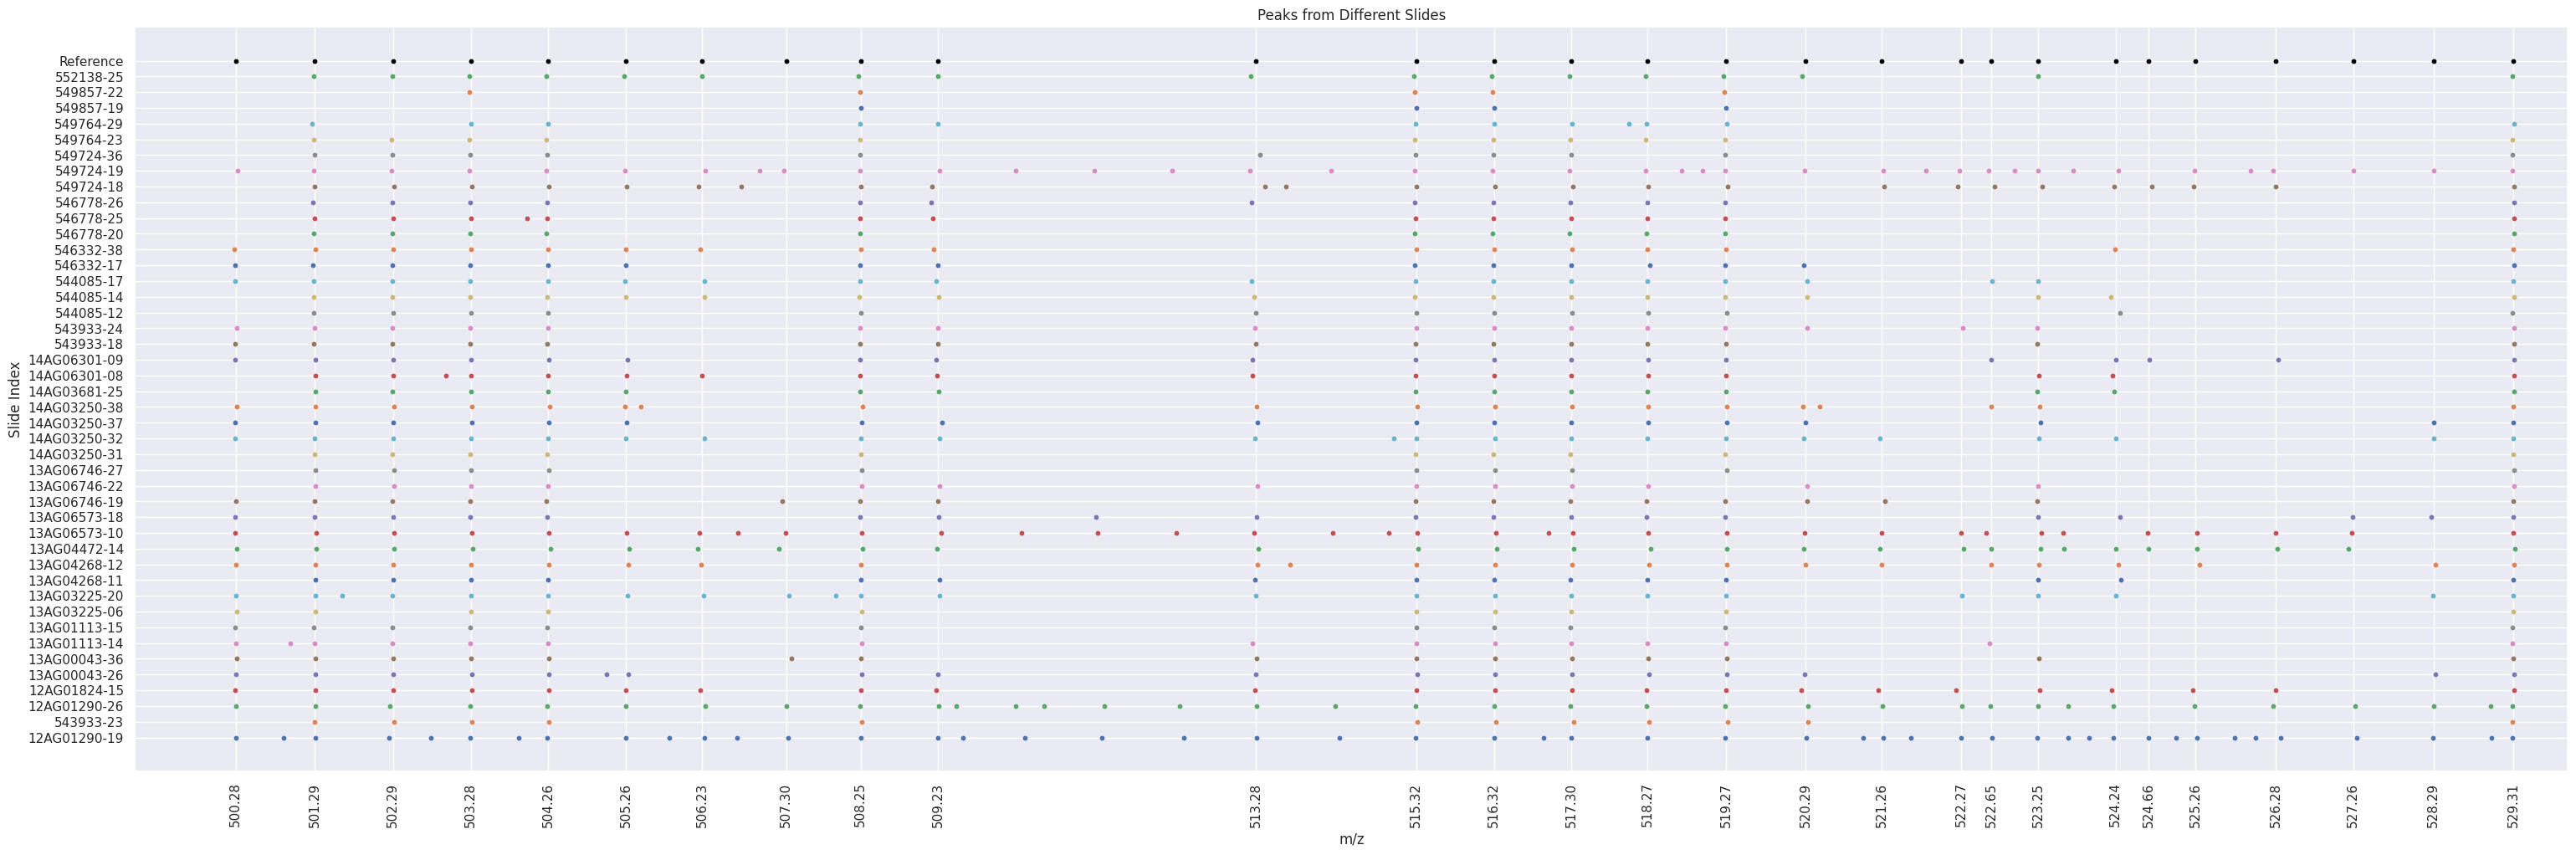

In [ ]:
# Define the limits for the x-axis
limits = [499, 530]

# Load the reference peaks
mass_ref = peaks_ref['mass'].values

# plotting the peaks
plt.figure(figsize=(30, 10))

# Plotting peaks from each slide
for i, slide in enumerate(slides):
    peaks = pd.read_csv(f"{PATH_TO_DATA}/{slide}/results/peaks_mz.csv")
    peaks = peaks[peaks['count'] > 50]['mass'].values
    plt.scatter(peaks, np.zeros_like(peaks) + i, s=10, label=slide)

# Plotting the reference peaks
plt.scatter(x=mass_ref, y=np.zeros_like(mass_ref) + i+1, s=10, label='reference', color='black')

plt.xlabel('m/z')
plt.ylabel('Slide Index')
plt.title('Peaks from Different Slides')
plt.tight_layout()
plt.xlim(limits[0], limits[1])
plt.yticks(np.arange(len(slides)+1), slides + ['Reference'], fontsize=11)
plt.xticks(mass_ref[(mass_ref < limits[1]) & (mass_ref > limits[0])], rotation=90)
plt.show()

In [13]:
# saving the clusters to a CSV file
clusters_df.to_csv("data/MALDI_IHC/results/peaks_clusters.csv", index=False)